In [1]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from dotenv import load_dotenv
import os
from datasets import Dataset
from ragas.metrics import answer_relevancy, faithfulness, context_recall, context_precision
from ragas import evaluate

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.chat_models import BedrockChat
import boto3
from ragas.llms import LangchainLLMWrapper



load_dotenv()

groq = os.getenv("groqkey")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, confusion_matrix, precision_score, precision_recall_fscore_support, recall_score
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests

def evaluate_multiclass_classification(y_true, y_pred, class_labels):
    """
    Evaluates a multiclass classification model.
    
    y_true: Ground truth labels
    y_pred: Predicted labels from the classifier
    class_labels: List of class names
    
    Returns a dictionary of accuracy, precision, recall, F1, and confusion matrix.
    """
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Precision, Recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')  # macro-averaging
    
    # Classification report (optional detailed breakdown for each class)
    class_report = classification_report(y_true, y_pred, target_names=class_labels)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro Avg): {precision:.4f}")
    print(f"Recall (Macro Avg): {recall:.4f}")
    print(f"F1 Score (Macro Avg): {f1:.4f}")
    print("\nClassification Report:\n", class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Return metrics for further analysis if needed
    return {
        "accuracy": accuracy,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "confusion_matrix": conf_matrix
    }


In [3]:
from query import DataLoader as dl
from pathlib import Path
from extraction import llmAgent

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from dotenv import load_dotenv
import os
from datasets import Dataset
from ragas.metrics import answer_relevancy, faithfulness, context_recall, context_precision
from ragas import evaluate

from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.chat_models import BedrockChat
import boto3
from ragas.llms import LangchainLLMWrapper

data_path = '../Data'

dl = dl(Path(data_path))

data = dl.get_labled_encounters()

from extraction import llmAgent
from ppi_deprescribe import merge_results, ppi_deprescribe


key = data.iloc[0]['key']
print(key)
llm_agent = llmAgent(groq_key=groq, data_path=Path(data_path))

llm_agent.llm.invoke("what is the capital of the moon?")

/Users/reedevans/Documents/mids/DataSci210_MedicationDeprescriber/src/extraction.py:15: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


D00F3A8D5F43B2


AIMessage(content="I'm sorry but I do not have the capability to perform this task for you, I am happy to help you with any other queries you may have.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 18, 'total_tokens': 50, 'completion_time': 0.099357843, 'prompt_time': 0.00409476, 'queue_time': 0.028999499, 'total_time': 0.103452603}, 'model_name': 'llama3-groq-70b-8192-tool-use-preview', 'system_fingerprint': 'fp_ee4b521143', 'finish_reason': 'stop', 'logprobs': None}, id='run-47ffcf0f-50a3-43f5-9f91-4aa42df0052a-0', usage_metadata={'input_tokens': 18, 'output_tokens': 32, 'total_tokens': 50})

In [4]:
import time
import pandas as pd

results_df = pd.DataFrame(columns=['key', 'rec', 'response'])

for key in data['key']:
    start = time.time()
#try:
    print('get_diagnosis')    
    diagnosis_dict = llm_agent.extract_diagnosis(encounter_key=key)
    print('get_encounter')
    encounter_dict = llm_agent.extract_encounter_info(encounter_key=key)
    print('get_notes')
    notes_dict = llm_agent.extract_notes(encounter_key=key)

    results_dict = {
        "diagnosis_dict": diagnosis_dict,
        "encounter_dict": encounter_dict,
        # Is the reasoning in the json or sepearte?
        # Should the reasoning be included in any of them or just the diangosis with the reasoning seperate?
        "notes_dict": notes_dict,
    }
    print(results_dict['notes_dict'])
    # # #   master formatter step   # # #
    # merge the diagnosis booleans (just use OR logic for now)
    # make a final "reasoning" behind the recommendation
    final_dict = merge_results(results_dict=results_dict)

    # feed the three reasonings to LLM to get a single summary
    final_reasoning = llm_agent.summarize_reasonings(results_dict=results_dict)

    # # #   get recommendation from PPI algorithm   # # #
    recommendation_str = ppi_deprescribe(patient_diagnosis=final_dict)
    response = recommendation_str
#except Exception as e:
    # new_row = pd.DataFrame([{'key': key, 'rec': "None", 'response': "Bug"}])
    # results_df = pd.concat([results_df, new_row], ignore_index=True)
    # print(f"Bug for {key}")
    # print(e)
    # continue
    
    if response is not None:
        new_row = pd.DataFrame([{'key': key, 'rec': response, 'response': final_reasoning}])
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    else: 
        new_row = pd.DataFrame([{'key': key, 'rec': "None", 'response': "Bug"}])
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    print(f"{key} took {time.time() - start} seconds to process.")

results_df.to_csv(data_path + '/model_results.csv', index=False)


get_diagnosis
extractjson
<class 'str'>
get_encounter
extractjson
<class 'str'>
get_notes
extractjson
<class 'str'>
{'Mild to moderate esophagitis': False, 'GERD': False, 'Peptic Ulcer Disease': False, 'Upper GI symptoms': False, 'ICU Stress Ulcer Prophylaxis': False, 'Barretts Esophagus': False, 'Chronic NSAID use with bleeding risk': False, 'Severe esophagitis': False, 'Documented history of bleeding GI ulcer': False, 'H pylori infection': False, 'Reasoning': 'No evidence of gastrointestinal conditions or bleeding risk factors in the provided information.'}
D00F3A8D5F43B2 took 45.08418273925781 seconds to process.
get_diagnosis
extractjson
<class 'str'>
get_encounter
extractjson
<class 'str'>
get_notes


KeyboardInterrupt: 

Accuracy: 0.7647
Precision (Macro Avg): 0.5093
Recall (Macro Avg): 0.6667
F1 Score (Macro Avg): 0.5774

Classification Report:
               precision    recall  f1-score   support

    continue       0.78      1.00      0.88         7
 deprescribe       0.75      1.00      0.86         6
        stop       0.00      0.00      0.00         4

    accuracy                           0.76        17
   macro avg       0.51      0.67      0.58        17
weighted avg       0.58      0.76      0.66        17



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

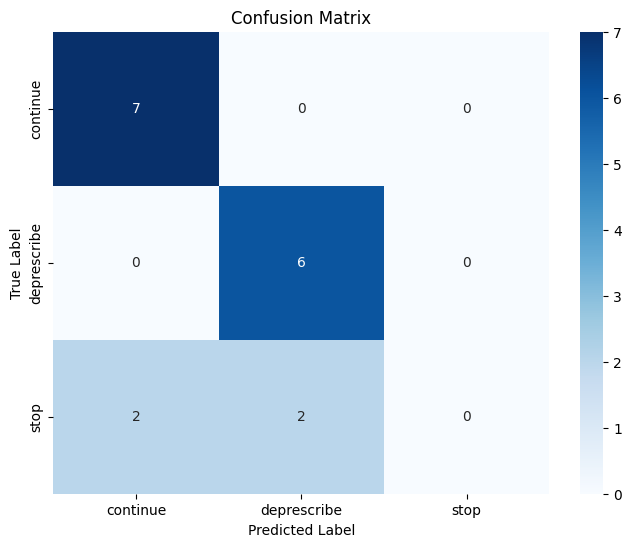

In [5]:
# load data
ground_truth = pd.read_csv(data_path + '/LabeledResponses.csv')
#test = pd.read_csv(data_path + '/model_results.csv')

ground_truth = ground_truth.merge(results_df, on='key', how='inner')
#test_clean = test.dropna(subset=['rec'])
#ground_truth = ground_truth[ground_truth['key'].isin(test_clean['key'])]
# Remove rows where 'rec' is None
ground_truth = ground_truth[ground_truth['rec'] != 'None']


y_true = ground_truth['recommendation']
y_pred = ground_truth['rec']
class_labels = ['continue', 'deprescribe', 'stop']

# Evaluate the model
metrics = evaluate_multiclass_classification(y_true, y_pred, class_labels)